# Package

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# importation des données

In [17]:
df_stationary_train = pd.read_csv("df_stationary_train.csv", index_col="date")
df_stationary_train.index = pd.to_datetime(df_stationary_train.index)
df_stationary_test = pd.read_csv("df_stationary_test.csv", index_col="date")
df_stationary_test.index = pd.to_datetime(df_stationary_test.index)

In [18]:
df_stationary_train

,UNRATE,TB3MS,RPI,INDPRO,DPCERA3M086SBEA,S&P 500,BUSLOANS,CPIAUCSL,OILPRICEx,M2SL,USREC
date,,,,,,,,,,,
1960-01-31,-0.8,0.30,0.020977,0.091980,0.001204,0.017909,0.011578,-0.006156,0.000000,0.001323,0
1960-02-29,-1.1,-0.19,0.014565,0.076964,0.006009,-0.025663,0.011905,-0.003767,0.000000,0.002007,0
1960-03-31,-0.2,-1.18,0.006250,0.007961,0.021240,-0.070857,-0.008356,-0.005455,0.000000,0.001324,0
1960-04-30,0.0,-1.12,0.006489,-0.025915,0.033752,-0.040442,-0.009098,0.005090,0.000000,0.000634,1
1960-05-31,0.0,-0.67,0.007747,-0.018121,0.009040,-0.010090,-0.000359,0.003383,0.000000,0.003977,1
...,...,...,...,...,...,...,...,...,...,...,...
1989-07-31,-0.2,-0.77,0.001769,-0.015259,0.003755,0.093414,-0.002184,-0.004246,-0.225652,0.010549,0
1989-08-31,-0.4,-0.53,0.008277,-0.000039,0.014490,0.099097,0.005449,-0.010676,-0.195045,0.014176,0
1989-09-30,-0.1,-0.40,0.008246,-0.003350,0.010644,0.070372,0.007701,-0.009804,-0.049151,0.011753,0


In [19]:
df_stationary_train_unrate = df_stationary_train["UNRATE"]
df_stationary_test_unrate = df_stationary_test["UNRATE"]

In [20]:
df_stationary_train_unrate

date
1960-01-31   -0.8
1960-02-29   -1.1
1960-03-31   -0.2
1960-04-30    0.0
1960-05-31    0.0
             ... 
1989-07-31   -0.2
1989-08-31   -0.4
1989-09-30   -0.1
1989-10-31   -0.1
1989-11-30    0.1
Name: UNRATE, Length: 359, dtype: float64

# AR(1)

## Autocorrélation

<Figure size 640x480 with 0 Axes>

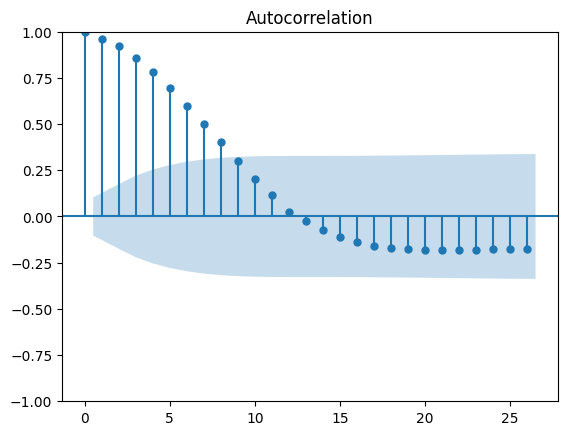

In [21]:
plt.figure()
plot_acf(df_stationary_train_unrate)
plt.show()

<Figure size 640x480 with 0 Axes>

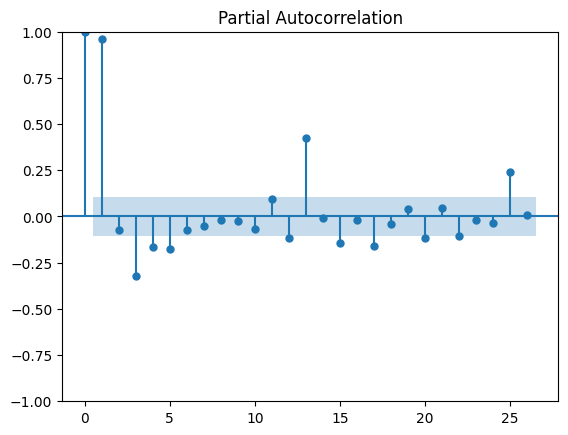

In [22]:
plt.figure()
plot_pacf(df_stationary_train_unrate)
plt.show()

Le graphique ACF montre une décroissance progressive et régulière vers zéro → typique d’un processus autorégressif (AR).

Le graphique PACF présente une coupure nette après le lag 1, c’est-à-dire que seule la première autocorrélation partielle est significative.

La série suit très probablement un modèle AR(1) (autorégressif d’ordre 1).

# Implémentation de AR(1)

In [33]:
import numpy as np
import pandas as pd
import pickle
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Série cible déjà différenciée (ΔUNRATE) ---
y = df_stationary_train_unrate.sort_index().astype(float).dropna()

# Index mensuel (début de mois)
y.index = pd.DatetimeIndex(pd.to_datetime(y.index)).to_period("M").to_timestamp()
y = y.asfreq("MS")

# --- Paramètres ---
h = 12
min_train_n = 36  # au moins 3 ans de données
eval_start = pd.Timestamp("1983-01-01")
eval_end   = pd.Timestamp("1989-12-31")

# --- Expanding + prévision h=12 ---
rows = []
last_model = None
last_fit_end = None

last_t_end = y.index.max() - relativedelta(months=h)

for t_end in y.index:
    if t_end > last_t_end:
        break

    # Entraînement progressif
    y_tr = y.loc[:t_end].dropna()
    if len(y_tr) < min_train_n:
        continue

    ar1 = AutoReg(y_tr, lags=1, old_names=False).fit()
    last_model = ar1
    last_fit_end = t_end

    # Prévisions à h=12
    fc = ar1.predict(start=len(y_tr), end=len(y_tr) + h - 1)
    yhat_h = float(fc.iloc[-1])

    t_fore = t_end + relativedelta(months=h)
    if t_fore in y.index:
        rows.append((t_fore, yhat_h, float(y.loc[t_fore])))

# --- Agrégation des prévisions ---
if rows:
    df_oos_ar1 = (
        pd.DataFrame(rows, columns=["date", "y_hat", "y_true"])
        .set_index("date")
        .sort_index()
    )
else:
    df_oos_ar1 = pd.DataFrame(columns=["y_hat", "y_true"])
    df_oos_ar1.index = pd.to_datetime(pd.Index([]))
    print("⚠️ Pas de prévisions générées.")

# --- 🔹 Restriction à 1983–1989 pour l’évaluation et la sauvegarde ---
df_eval = df_oos_ar1.loc[eval_start:eval_end].copy()

if len(df_eval) > 0:
    mae  = mean_absolute_error(df_eval["y_true"], df_eval["y_hat"])
    rmse = np.sqrt(mean_squared_error(df_eval["y_true"], df_eval["y_hat"]))
    r2   = r2_score(df_eval["y_true"], df_eval["y_hat"]) if len(df_eval) > 1 else np.nan

    print(f"\n✅ AR(1) OOS (h=12) — Évaluation sur 1983–1989 — n={len(df_eval)}")
    print(f"MAE = {mae:.3f} | RMSE = {rmse:.3f} | R² = {r2:.3f}")

    # Détails annuels
    df_eval["year"] = df_eval.index.year
    yearly = (
        df_eval.groupby("year")[["y_true", "y_hat"]]
        .apply(lambda g: pd.Series({
            "n": len(g),
            "MAE": mean_absolute_error(g["y_true"], g["y_hat"]),
            "RMSE": np.sqrt(mean_squared_error(g["y_true"], g["y_hat"]))
        }))
    )
    print("\n--- MAE/RMSE par année (1983–1989) ---")
    print(yearly.to_string())
else:
    print("⚠️ Aucune observation dans la fenêtre 1983–1989.")


✅ AR(1) OOS (h=12) — Évaluation sur 1983–1989 — n=83
MAE = 0.978 | RMSE = 1.461 | R² = -1.724

--- MAE/RMSE par année (1983–1989) ---
         n       MAE      RMSE
year                          
1983  12.0  1.895235  2.356209
1984  12.0  2.257664  2.595748
1985  12.0  1.129074  1.240798
1986  12.0  0.175455  0.232867
1987  12.0  0.787346  0.818619
1988  12.0  0.301074  0.381930
1989  11.0  0.235163  0.265309


In [34]:
# === Extraction propre depuis last_model (AutoRegResultsWrapper) ===
m = last_model

# 1) Série observée (y_true) + index temporel si dispo
try:
    idx = m.model.data.row_labels
except Exception:
    idx = None

y_true = pd.Series(m.model.endog, name="y_true")
if idx is not None and len(idx) == len(y_true):
    y_true.index = pd.Index(idx, name="date")

# 2) Fitted values in-sample (1-step-ahead), alignées à l'index
y_pred_insample = m.fittedvalues.rename("y_pred")
# Concat & aperçu (les premières valeurs peuvent être NaN à cause du lag)
df_insample = pd.concat([y_true, y_pred_insample], axis=1)

print("Aperçu (fin) y_true vs y_pred (in-sample 1-step):")
print(df_insample.tail(10))

# 3) (Optionnel) afficher l'ordre p utilisé par AutoReg
try:
    # AutoReg stocke la liste des lags -> ordre p = len(lags)
    lags = getattr(m.model, "lags", None)
    p_used = len(lags) if lags is not None else getattr(m, "k_ar", None)
    print(f"\nOrdre AR utilisé (p) : {p_used}")
except Exception:
    pass

Aperçu (fin) y_true vs y_pred (in-sample 1-step):
            y_true    y_pred
date                        
1988-02-01    -0.9 -0.865934
1988-03-01    -0.9 -0.865934
1988-04-01    -0.9 -0.865934
1988-05-01    -0.7 -0.865934
1988-06-01    -0.8 -0.673279
1988-07-01    -0.7 -0.769606
1988-08-01    -0.4 -0.673279
1988-09-01    -0.5 -0.384295
1988-10-01    -0.6 -0.480623
1988-11-01    -0.5 -0.576951

Ordre AR utilisé (p) : None


In [35]:
# --- 💾 Sauvegarde uniquement du modèle et métadonnées post-1983 ---
if last_model is not None:
    with open("AR1_last_trained_model.pkl", "wb") as f:
        pickle.dump(last_model, f)

    ar1_meta = {
        "trained_until": str(last_fit_end),
        "p_used": getattr(last_model, "k_ar", 1),
        "nobs": getattr(last_model, "nobs", np.nan),
        "aic": getattr(last_model, "aic", np.nan),
        "bic": getattr(last_model, "bic", np.nan),
        "eval_start": str(eval_start.date()),
        "eval_end": str(eval_end.date()),
        "mae_83_89": float(mae) if len(df_eval) > 0 else np.nan,
        "rmse_83_89": float(rmse) if len(df_eval) > 0 else np.nan,
        "r2_83_89": float(r2) if len(df_eval) > 0 else np.nan,
        "n_eval": len(df_eval),
    }

    pd.Series(ar1_meta).to_csv("AR1_last_trained_model_meta.csv")

    print("\n💾 Modèle AR(1) sauvegardé : AR1_last_trained_model.pkl")
    print(f"   Meta: {ar1_meta}")
else:
    print("\n⚠️ Aucun modèle AR(1) entraîné trouvé pour la sauvegarde.")


💾 Modèle AR(1) sauvegardé : AR1_last_trained_model.pkl
   Meta: {'trained_until': '1988-11-01 00:00:00', 'p_used': 1, 'nobs': 346, 'aic': np.float64(164.6473364963893), 'bic': np.float64(176.18665282156246), 'eval_start': '1983-01-01', 'eval_end': '1989-12-31', 'mae_83_89': 0.9775539701031503, 'rmse_83_89': 1.4610097145509617, 'r2_83_89': -1.7237671605297926, 'n_eval': 83}


# AR(p) automatique

j'ai choisi alors p = 3 

In [11]:
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ====== Série cible déjà stationnaire (ΔUNRATE) ======
y = df_stationary_train_unrate.sort_index().astype(float).dropna()
y.index = pd.DatetimeIndex(pd.to_datetime(y.index)).to_period("M").to_timestamp()
y = y.asfreq("MS")

# ====== Paramètres ======
max_p = 12
h = 12
min_train_n = 36
start_cv = pd.Timestamp("1983-01-01")     # début des re-tunings
tune_every_months = 36                    # tous les 36 mois
cv_start_global = pd.Timestamp("1960-01-01")  # expanding depuis 1960

eval_start = pd.Timestamp("1983-01-01")
eval_end   = pd.Timestamp("1989-12-31")

last_date = y.index.max()
last_train_end = last_date - relativedelta(months=h)

In [12]:
# ====== Helpers ======
def can_fit_segment(y_tr, p, extra_df=2):
    # n_effective = len(y_tr) - p
    # k = p + 1 (constante)
    # on exige n_effective - k > 0  <=> len(y_tr) >= 2*p + 2
    if y_tr is None:
        return False
    n = len(y_tr)
    if np.nanstd(y_tr.values) == 0:
        return False
    if n < max(2*p + 2, p + 1 + extra_df):   # renforce la contrainte
        return False
    return True

def perf(y_true, y_pred):
    if len(y_true) == 0:
        return {"MAE":np.nan, "RMSE":np.nan, "R2":np.nan}
    return {
        "MAE":  float(mean_absolute_error(y_true, y_pred)),
        "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "R2":   float(r2_score(y_true, y_pred)) if len(y_true) > 1 else np.nan
    }

def select_p_by_oos_mae_expanding(y, t_end, h, max_p, cv_start_global, min_cv_points=8):
    """
    À la date t_end (incluse), choisit p∈[1,max_p] qui minimise la MAE des
    prévisions h-pas-ahead, en CV *expanding* depuis cv_start_global
    jusqu'à t_end - h (jamais au-delà de t_end).
    """
    window_start = max(y.index.min(), cv_start_global)
    last_cv_end = t_end - relativedelta(months=h)
    if last_cv_end < window_start:
        return None

    maes = {}
    cv_train_ends = pd.date_range(window_start, last_cv_end, freq="MS")

    for p in range(1, max_p+1):
        ae = []
        for t_cv_end in cv_train_ends:
            y_tr = y.loc[:t_cv_end].dropna()
            if not can_fit_segment(y_tr, p, extra_df=2):
                continue
            res = AutoReg(y_tr, lags=p, old_names=False).fit()
            fc = res.forecast(steps=h)
            yhat_h = float(np.asarray(fc)[-1])
            t_h = t_cv_end + relativedelta(months=h)
            if t_h in y.index:
                ae.append(abs(yhat_h - float(y.loc[t_h])))
        if len(ae) >= min_cv_points:
            maes[p] = float(np.mean(ae))

    if not maes:
        return None
    best_mae = min(maes.values())
    best_ps = [pp for pp,v in maes.items() if v == best_mae]
    return min(best_ps)


In [13]:
import numpy as np
import pandas as pd
import pickle
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ====== AR_auto avec re-tuning tous les 36 mois (1983–1989), CV expanding depuis 1960 ======
preds_auto = []
p_used_timeline = []
p_current = 1
last_tune_date = None

# Pour retenir le meilleur modèle sur 1983–1989
eval_start = pd.Timestamp("1983-01-01")
eval_end   = pd.Timestamp("1989-12-31")
best_mae = np.inf
best_model = None
best_model_meta = None   # (date d'entraînement, p utilisé)

for t_end in y.index:
    if t_end > last_train_end:
        break

    y_tr = y.loc[:t_end].dropna()
    if not can_fit_segment(y_tr, max_p, extra_df=2):
        continue

    # re-tuning déclenché à partir de 1983 et ensuite tous les 36 mois
    need_tune = False
    if (last_tune_date is None) and (t_end >= start_cv):
        need_tune = True
    elif last_tune_date is not None:
        months_since = (t_end.year - last_tune_date.year)*12 + (t_end.month - last_tune_date.month)
        if months_since >= tune_every_months:
            need_tune = True

    if need_tune:
        best_p = select_p_by_oos_mae_expanding(
            y=y, t_end=t_end, h=h, max_p=max_p,
            cv_start_global=cv_start_global, min_cv_points=8
        )
        if best_p is not None:
            p_current = best_p
            last_tune_date = t_end

    # fit AR(p_current) et prévoir t_end + h
    if not can_fit_segment(y_tr, p_current, extra_df=2):
        continue
    res = AutoReg(y_tr, lags=p_current, old_names=False).fit()
    fc = res.forecast(steps=h)
    yhat_h = float(np.asarray(fc)[-1])
    t_h = t_end + relativedelta(months=h)

    if t_h in y.index:
        preds_auto.append((t_h, yhat_h, float(y.loc[t_h]), p_current))
        p_used_timeline.append((t_h, p_current))

        # --- évalue MAE cumulée sur la fenêtre 1983–1989 et garde le meilleur modèle ---
        if (t_h >= eval_start) and (t_h <= eval_end):
            df_tmp = (pd.DataFrame(preds_auto, columns=["date","y_hat","y_true","p_used"])
                        .set_index("date").sort_index())
            df_tmp_eval = df_tmp.loc[eval_start:eval_end]
            if len(df_tmp_eval) > 0:
                mae_now = mean_absolute_error(df_tmp_eval["y_true"], df_tmp_eval["y_hat"])
                if mae_now < best_mae:
                    best_mae = mae_now
                    best_model = res
                    best_model_meta = {"trained_until": t_end, "p_used": p_current, "mae_83_89": float(mae_now)}

# ====== Évaluation stricte 1983–1989 ======
if preds_auto:
    df_oos_ar_auto = (pd.DataFrame(preds_auto, columns=["date","y_hat","y_true","p_used"])
                        .set_index("date").sort_index())
    df_eval = df_oos_ar_auto.loc[eval_start:eval_end].copy()

    if len(df_eval) > 0:
        mae = mean_absolute_error(df_eval["y_true"], df_eval["y_hat"])
        rmse = np.sqrt(mean_squared_error(df_eval["y_true"], df_eval["y_hat"]))
        r2 = (1 - (rmse**2) / np.var(df_eval["y_true"], ddof=0)) if len(df_eval) > 1 else np.nan

        print("=== AR_auto (re-tuning tous les 36 mois, CV expanding depuis 1960) — Évaluation 1983–1989 ===")
        print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")

        # fréquences des p utilisés (sur 83–89)
        p_counts = df_eval["p_used"].value_counts().sort_index()
        print("\nFréquences des ordres p sélectionnés (1983–1989) :")
        print(p_counts.to_string())

        # (optionnel) perfs annuelles
        df_eval["year"] = df_eval.index.year
        yearly = (df_eval.groupby("year")
                        .apply(lambda g: pd.Series({
                            "n": len(g),
                            "MAE": mean_absolute_error(g["y_true"], g["y_hat"]),
                            "RMSE": np.sqrt(mean_squared_error(g["y_true"], g["y_hat"]))
                        })))
        print("\n--- MAE/RMSE par année (1983–1989) ---")
        print(yearly.to_string())
    else:
        print("⚠️ Aucune observation dans la fenêtre d'évaluation 1983–1989.")
else:
    print("⚠️ Aucun point OOS produit (vérifie la couverture de y et les paramètres).")

# ====== 💾 Sauvegarde du meilleur modèle sur 1983–1989 ======
if best_model is not None:
    with open("AR_auto_best_model_1983_1989.pkl", "wb") as f:
        pickle.dump(best_model, f)
    # méta-infos utiles pour traçabilité
    pd.Series(best_model_meta).to_csv("AR_auto_best_model_1983_1989_meta.csv")
    print("\n💾 Meilleur modèle sauvegardé : AR_auto_best_model_1983_1989.pkl")
    print(f"   Meta: {best_model_meta}")
else:
    print("\n⚠️ Aucun 'meilleur modèle' identifié dans 1983–1989 (pas de points ou MAE non définie).")

=== AR_auto (re-tuning tous les 36 mois, CV expanding depuis 1960) — Évaluation 1983–1989 ===
MAE=0.829 | RMSE=1.303 | R²=-1.166

Fréquences des ordres p sélectionnés (1983–1989) :
p_used
1    12
3    71

--- MAE/RMSE par année (1983–1989) ---
         n       MAE      RMSE
year                          
1983  12.0  1.895235  2.356209
1984  12.0  1.932664  2.207116
1985  12.0  0.281222  0.450521
1986  12.0  0.225631  0.301919
1987  12.0  0.834345  0.870892
1988  12.0  0.392712  0.464643
1989  11.0  0.186938  0.225853

💾 Meilleur modèle sauvegardé : AR_auto_best_model_1983_1989.pkl
   Meta: {'trained_until': Timestamp('1982-04-01 00:00:00'), 'p_used': 1, 'mae_83_89': 0.5702235908150677}


C:\Users\Mita\AppData\Local\Temp\ipykernel_10996\4237559878.py:93: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [14]:
import pickle
from datetime import timedelta

# Recharger le modèle
with open("AR_auto_best_model_1983_1989.pkl", "rb") as f:
    best_model = pickle.load(f)

In [15]:
# Coefficients estimés
print(best_model.params)

# Valeurs t-statistiques et p-values
print(best_model.tvalues)
print(best_model.pvalues)

# R², AIC, BIC, etc.
print(best_model.summary())

const        0.015156
UNRATE.L1    0.962028
dtype: float64
const         0.798312
UNRATE.L1    53.985144
dtype: float64
const        0.42469
UNRATE.L1    0.00000
dtype: float64
                            AutoReg Model Results                             
Dep. Variable:                 UNRATE   No. Observations:                  268
Model:                     AutoReg(1)   Log Likelihood                 -64.832
Method:               Conditional MLE   S.D. of innovations              0.308
Date:                Thu, 16 Oct 2025   AIC                            135.664
Time:                        17:33:30   BIC                            146.425
Sample:                    02-01-1960   HQIC                           139.987
                         - 04-01-1982                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0152      0.019 